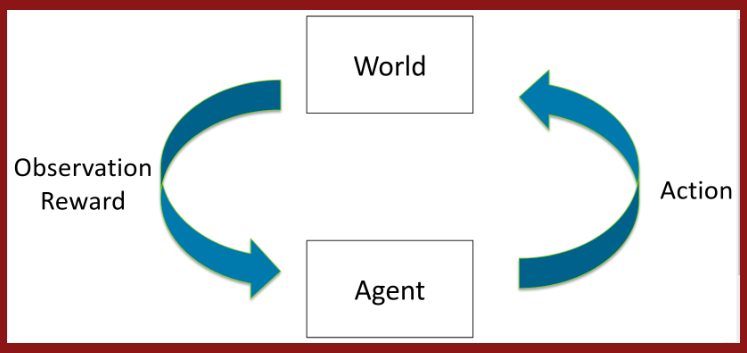

In [3]:
"""
In Reinforcement Learning, the agent (or the learner) interacts with the world (environment) to optimize the rewards.
The environment gives the agent initial observation of the world (we will call this the start state). Given the start state,
the Agent picks an action based on a policy or some value function. With this action, the environment creates a new state
and a reward as a result of taking that action. Given this reward, the agent optimizes its parameters depending on the type
of algorithm the agent uses.

Deepmind's David Silver lectures on RL + Sutton and Barto Intro to RL

The first algorithm of the tutorial is Q-learning. The q-fucntion is a function that approximates the value of 
state-action pairs. The value here would be current reward and the expected future rewards (estimated by a function 
approximator, both linear and non-linear)

In the code implemented below, I build two neural networks of same structure but different weights to approximate our 
state-action value function, or Q-function- hence the name, Q-learning.

We keep two neural networks, target-Q network and Q-network, with different weights to approximate
state-action value function (Q-Function). The active Q-network gets updated at every step while the target network gets 
updated periodically by copying the weights of the Q-network

The agent plays the game and keeps its observations (state, action taken, reward) in the replay buffer.
(Note. This replay buffer is implemented in utils folder along with other utility functions.)

Then, during training, agent randomly takes n (=batch size) samples from the replay buffer to calculate loss and 
update network parameters. 

The paper uses MSE loss, which is explained below. 
              Q_samp(s) = r if done
                        = r + gamma * max_a' Q_target(s', a')
            loss = (Q_samp(s) - Q(s, a))^2
Simply put, the loss is:
(Actual reward from action + future expected reward) - (what we estimated would be the value if we take this action)

Note: 1. we use Q_target to get expected maximum future reward given our new state
      2. we use active Q-network to get the value -"what we thought would have happened"
      
This way, our loss becomes (what actually happened) - (what we thought would have happened)

See code for implementation details! 
            
            """

print("")

In [ ]:
"""
There are two abstract classes implemented for Q_network and Deep Q_network. 
It contains general code for training, testing.The customizable code will be based off of these two classes. 
To understand the training process, please look at these abstract classes.

There are multiple utility functions and classes implemented in the utils folder. Please take a look if interested 
in the inner workings of the algorithm.

Code is complete and does not need any configuration other than changing the configurations (config) and the network structure
Currently, I have implemented a Linear network and a Convolution network like Deepmind's Atari paper:
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

"""

In [ ]:
#First we implement a basic DQN agent using fully connected linear neural networks
import copy
import io

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from DQN.utils.test_env import EnvTest
from DQN.core.deep_q_learning_torch import DQN
from DQN.q4_schedule import LinearExploration, LinearSchedule

from configs.q5_linear import config

class Linear(DQN):
    def initialize_models(self):
        """Creates the 2 separate networks (Q network and Target network). The input
        to these models will be an img_height * img_width image
        with channels = n_channels * self.config.state_history

        1. Set self.q_network to be a linear layer with num_actions as the output size
        2. Set self.target_network to be the same configuration self.q_network but initialized from scratch
        3. What is the input size of the model?
        """
        # this information might be useful
        state_shape = list(self.env.observation_space.shape)
        img_height, img_width, n_channels = state_shape
        num_actions = self.env.action_space.n

        self.q_network=torch.nn.Linear(img_height*img_width*n_channels*self.config.state_history, num_actions)
        self.target_network = torch.nn.Linear(img_height*img_width*n_channels*self.config.state_history, num_actions)



    def get_q_values(self, state, network='q_network'):
        """
        Returns Q values for all actions

        Args:
            state: (torch tensor)
                shape = (batch_size, img height, img width, nchannels x config.state_history)
            network: (str)
                The name of the network, either "q_network" or "target_network"

        Returns:
            out: (torch tensor) of shape = (batch_size, num_actions)
            """

        if network=="q_network":
            out= self.q_network(torch.flatten(state, start_dim=1))
        else:
            out= self.target_network(torch.flatten(state, start_dim=1))

        return out


    def update_target(self):
        """
        update_target_op will be called periodically
        to copy Q network weights to target Q network

        Remember that in DQN, we maintain two identical Q networks with
        2 different sets of weights.

        Periodically, we need to update all the weights of the Q network
        and assign them with the values from the regular network.
        """

        torch.save(self.q_network, "q_network_weights")
        self.target_network=torch.load("q_network_weights")



    def calc_loss(self, q_values : Tensor, target_q_values : Tensor,
                    actions : Tensor, rewards: Tensor, done_mask: Tensor) -> Tensor:
        """
        Calculate the MSE loss of this step.
        The loss for an example is defined as:
            Q_samp(s) = r if done
                        = r + gamma * max_a' Q_target(s', a')
            loss = (Q_samp(s) - Q(s, a))^2

        Args:
            q_values: (torch tensor) shape = (batch_size, num_actions)
                The Q-values that your current network estimates (i.e. Q(s, a') for all a')
            target_q_values: (torch tensor) shape = (batch_size, num_actions)
                The Target Q-values that your target network estimates (i.e. (i.e. Q_target(s', a') for all a')
            actions: (torch tensor) shape = (batch_size,)
                The actions that you actually took at each step (i.e. a)
            rewards: (torch tensor) shape = (batch_size,)
                The rewards that you actually got at each step (i.e. r)
            done_mask: (torch tensor) shape = (batch_size,)
                A boolean mask of examples where we reached the terminal state
        """
        # you may need this variable
        num_actions = self.env.action_space.n
        actions_taken=torch.nn.functional.one_hot(actions.to(torch.int64), num_classes=num_actions)
        q_val_after_done=~done_mask[:,None]*target_q_values

        max_q_target, max_q_target_idx = torch.max(q_val_after_done, dim=1)
        gamma = self.config.gamma
        q_samp = rewards + gamma * max_q_target
        q_sa=torch.sum(q_values*actions_taken, dim=1)

        loss=torch.nn.functional.mse_loss(q_samp, q_sa)
        return loss


    def add_optimizer(self, lr=0.00001):
        """
        Set self.optimizer to be an Adam optimizer optimizing only the self.q_network
        parameters
        """
        self.optimizer=torch.optim.Adam(self.q_network.parameters(), lr=lr)




if __name__ == '__main__':
    env = EnvTest((5, 5, 1))
    # log=logging.getLogger('matplotlib.font_manager').disabled = True

    # exploration strategy
    exp_schedule = LinearExploration(env, config.eps_begin,
            config.eps_end, config.eps_nsteps)

    # learning rate schedule
    lr_schedule  = LinearSchedule(config.lr_begin, config.lr_end,
            config.lr_nsteps)

    # train model
    model = Linear(env, config)
    model.run(exp_schedule, lr_schedule)



In [ ]:
#Configuration for running the test below!
class config():
    # env config
    render_train     = False
    render_test      = False
    overwrite_render = True
    record           = False
    high             = 255.

    # output config
    output_path  = "results/q5_linear/"
    model_output = output_path + "model.weights.pt"
    log_path     = output_path + "log.txt"
    plot_output  = output_path + "scores.png"

    # model and training config
    num_episodes_test = 20
    grad_clip         = True
    clip_val          = 10
    saving_freq       = 5000
    log_freq          = 50
    eval_freq         = 1000
    soft_epsilon      = 0

    # hyper params
    nsteps_train       = 10000
    batch_size         = 32
    buffer_size        = 1000
    target_update_freq = 500
    gamma              = 0.99
    learning_freq      = 4
    state_history      = 4
    lr_begin           = 0.005
    lr_end             = 0.001
    lr_nsteps          = nsteps_train/2
    eps_begin          = 1
    eps_end            = 0.01
    eps_nsteps         = nsteps_train/2
    learning_start     = 200

    
if __name__ == '__main__':
    env = EnvTest((5, 5, 1))
    # log=logging.getLogger('matplotlib.font_manager').disabled = True

    # exploration strategy
    exp_schedule = LinearExploration(env, config.eps_begin,
            config.eps_end, config.eps_nsteps)

    # learning rate schedule
    lr_schedule  = LinearSchedule(config.lr_begin, config.lr_end,
            config.lr_nsteps)

    # train model
    model = Linear(env, config)
    model.run(exp_schedule, lr_schedule)

In [1]:
#CNN version of DQN based off of Deepmind's Nature paper
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F

from utils.general import get_logger
from utils.test_env import EnvTest
from q4_schedule import LinearExploration, LinearSchedule
from q5_linear_torch import Linear


from configs.q6_nature import config

class NatureQN(Linear):
    """
    Implementing DeepMind's Nature paper. Here are the relevant urls.
    https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

    Model configuration can be found in the Methods section of the above paper.
    """

    def initialize_models(self):
        """Creates the 2 separate networks (Q network and Target network). The input
        to these models will be an img_height * img_width image
        with channels = n_channels * self.config.state_history
        
        The function achieves the following:
        
        1. Set self.q_network to be a model with num_actions as the output size
        2. Set self.target_network to be the same configuration self.q_network but initialized from scratch
        3. Input size is based off the image the agent sees in game

        To simplify, we specify the paddings as:
            (stride - 1) * img_height - stride + filter_size) // 2
    
    The exact architecture, shown schematically in Fig. 1 of the paper, is as follows. 
    The input to the neural network consists of an 84 x 84 x 4 image produced by the preprocessing map phi_.
    The first hidden layer convolves 32 filters of 8 x 8 with stride 4 with the input image and applies a rectifier nonlinearity
    The second hidden layer convolves 64 filters of 4 x 4 with stride 2, again followed by a rectifier nonlinearity.
    third convolutional layer that convolves 64 filters of 3 x 3 with stride 1 followed by a rectifier.
    The final hidden layer is fully-connected and consists of 512 rectifier units.
    The output layer is a fully-connected linear layer with a single output for each valid action.
    The number of valid actions varied between 4 and 18 on the games we considered.
        """
        state_shape = list(self.env.observation_space.shape)
        img_height, img_width, n_channels = state_shape
        num_actions = self.env.action_space.n

        self.q_network = nn.Sequential(
            nn.Conv2d(in_channels=n_channels*self.config.state_history,
                      out_channels=32,
                      kernel_size=8, stride=4,
                      padding=(3*img_height-4+8)//2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=4, stride=2,
                      padding=(1 * img_height - 2 + 4) // 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3, stride=1,
                      padding=(0 * img_height - 1 + 3) // 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(img_height*img_width*64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )
        self.target_network=nn.Sequential(
            nn.Conv2d(in_channels=n_channels*self.config.state_history,
                      out_channels=32,
                      kernel_size=8, stride=4,
                      padding=(3*img_height-4+8)//2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=4, stride=2,
                      padding=(1 * img_height - 2 + 4) // 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3, stride=1,
                      padding=(0 * img_height - 1 + 3) // 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(img_height*img_width*64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def get_q_values(self, state, network):
        """
        Returns Q values for all actions

        Args:
            state: (torch tensor)
                shape = (batch_size, img height, img width, nchannels x config.state_history)
            network: (str)
                The name of the network, either "q_network" or "target_network"

        Returns:
            out: (torch tensor) of shape = (batch_size, num_actions)
        """

        x=torch.stack([state[i].T for i in range(len(state))])
        if network=="q_network":
            out=self.q_network(x)
        else:
            out=self.target_network(x)

        return out


"""
Use deep Q network for test environment.
"""
if __name__ == '__main__':
    env = EnvTest((8, 8, 6))

    # exploration strategy
    exp_schedule = LinearExploration(env, config.eps_begin,
            config.eps_end, config.eps_nsteps)

    # learning rate schedule
    lr_schedule  = LinearSchedule(config.lr_begin, config.lr_end,
            config.lr_nsteps)

    # train model
    model = NatureQN(env, config)
    model.run(exp_schedule, lr_schedule)


In [ ]:
"""Testing on Atarin games"""
from q4_schedule import LinearExploration, LinearSchedule
from q5_linear_torch import Linear

from configs.q7_train_atari_linear import config

"""
Use linear approximation for the Atari game. Please report the final result.
Feel free to change the configurations (in the configs/ folder).
If so, please report your hyperparameters.

You'll find the results, log and video recordings of your agent every 250k under
the corresponding file in the results folder. A good way to monitor the progress
of the training is to use Tensorboard. The starter code writes summaries of different
variables.

To launch tensorboard, open a Terminal window and run
tensorboard --logdir=results/
Then, connect remotely to
address-ip-of-the-server:6006
6006 is the default port used by tensorboard.
"""
if __name__ == '__main__':
    # make env
    env = gym.make(config.env_name)
    env = MaxAndSkipEnv(env, skip=config.skip_frame)
    env = PreproWrapper(env, prepro=greyscale, shape=(80, 80, 1),
                        overwrite_render=config.overwrite_render)

    # exploration strategy
    exp_schedule = LinearExploration(env, config.eps_begin,
            config.eps_end, config.eps_nsteps)

    # learning rate schedule
    lr_schedule  = LinearSchedule(config.lr_begin, config.lr_end,
            config.lr_nsteps)

    # train model
    model = Linear(env, config)
    model.run(exp_schedule, lr_schedule)
